In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split #spliting
from sklearn.preprocessing import StandardScaler,MinMaxScaler #Scaling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

<h3>Data Prep</h3>

In [2]:
dataset = pd.read_csv('titanic.csv')
df_results = dataset.iloc[:,1].values
columns_to_exclude = [4, 9, 11]
selected_columns = [i for i in range(2, dataset.shape[1]) if i + 1 not in columns_to_exclude]
df_infos = dataset.iloc[:, selected_columns]
df_infos.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(df_infos.iloc[:, 2].values.reshape(-1, 1))
df_infos.iloc[:, 2] = imputer.transform(df_infos.iloc[:, 2].values.reshape(-1, 1))
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[1])],remainder='passthrough')
df_infos = np.array(ct.fit_transform(df_infos))
ct2 = ColumnTransformer(transformers=[('encoder',OneHotEncoder(),[-1])],remainder='passthrough')
df_infos = np.array(ct2.fit_transform(df_infos))

In [4]:
df_results_train , df_results_test , df_infos_train , df_infos_test = train_test_split(df_results, df_infos , test_size= 0.3, random_state= 0 )

In [5]:
sc = StandardScaler()
df_infos_train = sc.fit_transform(df_infos_train)
df_infos_test = sc.transform(df_infos_test)


<h3>Model</h3>

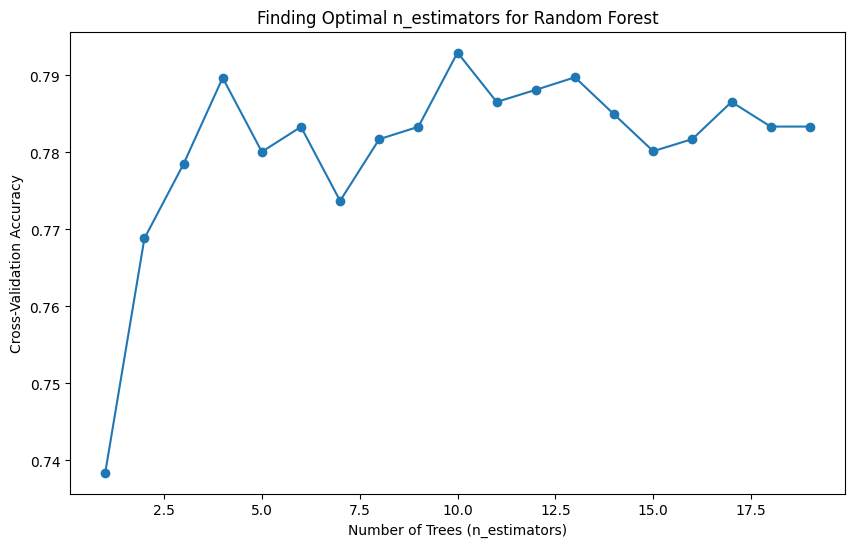

The optimal number of trees is 10


In [6]:
n_estimators_range = range(1, 20, 1)
cv_scores = []

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(model, df_infos_train, df_results_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

cv_scores = np.array(cv_scores)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, cv_scores, marker='o')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Finding Optimal n_estimators for Random Forest')
plt.show()

optimal_n_estimators = n_estimators_range[np.argmax(cv_scores)]
print(f'The optimal number of trees is {optimal_n_estimators}')

In [7]:
classifier = RandomForestClassifier(n_estimators = optimal_n_estimators, max_depth = 30, max_features = 'sqrt', min_samples_leaf =  1, min_samples_split =  2)
classifier.fit(df_infos_train,df_results_train)
pred_train = classifier.predict(df_infos_train)

<h3>Results on training Set</h3>

In [8]:
scores = cross_val_score(classifier, df_infos_train, df_results_train, cv=10)
print(f'Validação Cruzada: Média {scores.mean()}, Desvio Padrão {scores.std()}')

Validação Cruzada: Média 0.8009984639016896, Desvio Padrão 0.028537743477418873


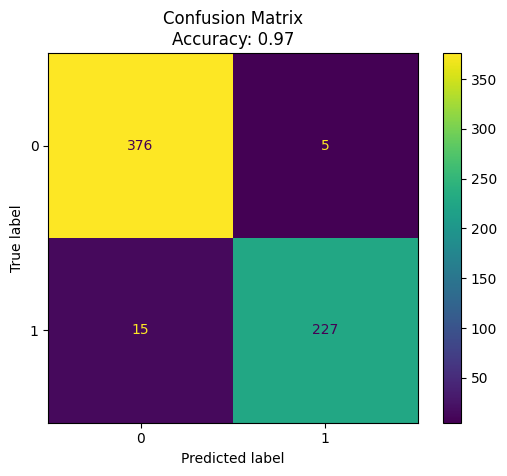

In [9]:
accuracy = accuracy_score(df_results_train, pred_train)
cm = confusion_matrix(df_results_train, pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

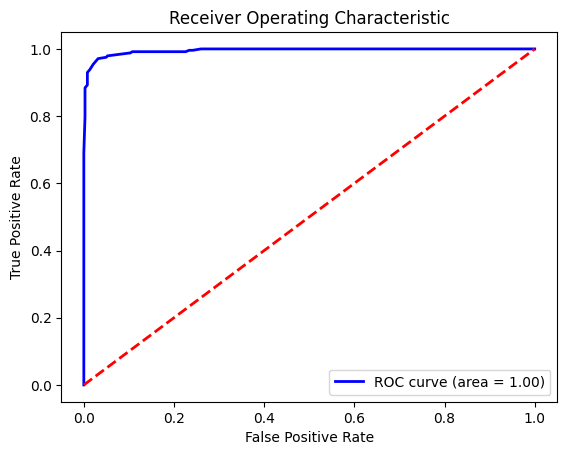

In [10]:
y_prob = classifier.predict_proba(df_infos_train)[:, 1]
fpr, tpr, thresholds = roc_curve(df_results_train, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

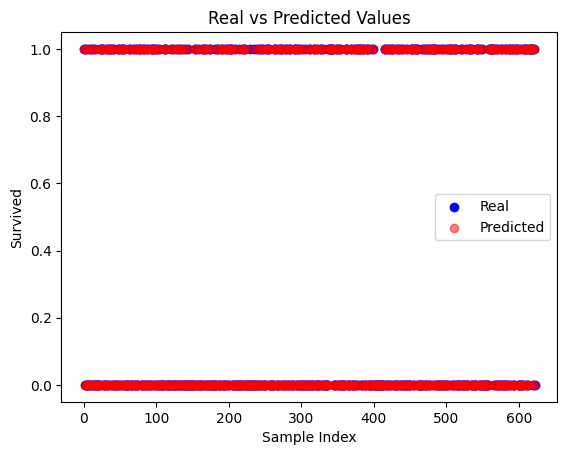

In [11]:
plt.scatter(range(len(df_results_train)), df_results_train, color='blue', label='Real')
plt.scatter(range(len(pred_train)), pred_train, color='red', alpha=0.5, label='Predicted')
plt.title('Real vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Survived')
plt.legend()
plt.show()


<h3>Results on Test Set</h3>

In [12]:
pred_test = classifier.predict(df_infos_test)

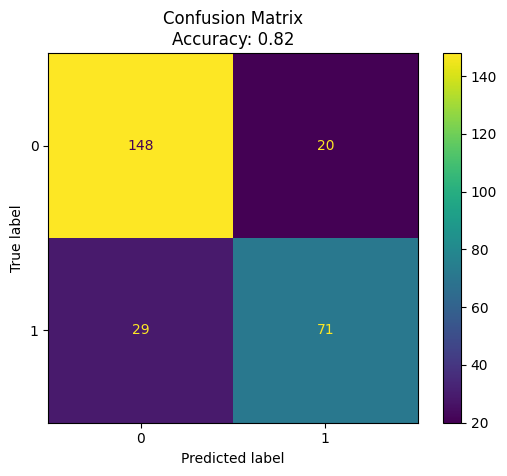

In [13]:
accuracy = accuracy_score(df_results_test, pred_test)
cm = confusion_matrix(df_results_test, pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
plt.show()

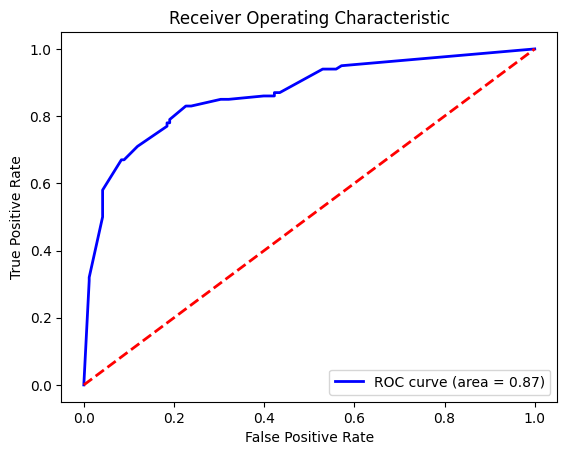

In [14]:
y_prob = classifier.predict_proba(df_infos_test)[:, 1]
fpr, tpr, thresholds = roc_curve(df_results_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

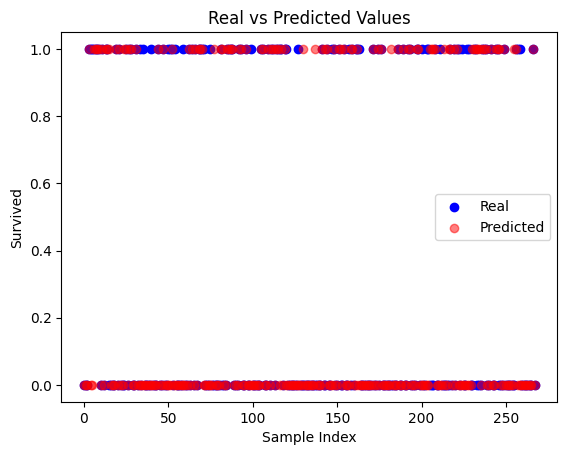

In [15]:
plt.scatter(range(len(df_results_test)), df_results_test, color='blue', label='Real')
plt.scatter(range(len(pred_test)), pred_test, color='red', alpha=0.5, label='Predicted')
plt.title('Real vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Survived')
plt.legend()
plt.show()